<a href="https://colab.research.google.com/github/flohmannjr/TCC530/blob/main/TCC530_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC530 - Modelos

## Importações de bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Bidirectional, Concatenate, Conv1D, Dense
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D, Input, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
!pip install -U "tensorflow-text==2.13.*"
import tensorflow_text as tf_text

## Configurações

In [3]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")

### Constantes

In [4]:
SEMENTE = 42

LIMITE_DICIONARIO = 90000

MAXIMO_MODELOS = 8

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

ESPACO_SAIDA = 128
NUCLEO_CONV = 5
NUCLEO_SAIDA = 64
PREENCHIMENTO = 'same'

ABANDONOS = 0.1

PERDA       = 'binary_crossentropy'
OTIMIZADOR  = Adam
APRENDIZADO = 0.0005
METRICAS    = ['accuracy']

ITERACOES = 3
ITERACOES_MLP = 20

## Dados

In [5]:
dados = pd.read_csv('https://raw.githubusercontent.com/Edvandro-Nogueira/TCC-Univesp/main/dados_noticias.csv',
                    sep=';')

In [6]:
dados = dados[dados['noticias'].notna()]

In [7]:
dados['palavras'] = dados['noticias'].str.split().str.len()

In [8]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10738 entries, 0 to 10757
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   noticias  10738 non-null  object
 1   classe    10738 non-null  int64 
 2   palavras  10738 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 335.6+ KB


In [9]:
dados

,noticias,classe,palavras
0,katia abreu diz vai colocar expulsao moldura n...,0,99
1,ray peita bolsonaro conservador fake entrevist...,0,143
2,reinaldo azevedo desmascarado policia federal ...,0,153
3,relatorio assustador bndes mostra dinheiro pub...,0,339
4,radialista americano fala sobre pt vendem ilus...,0,66
...,...,...,...
10753,"Aug 26, 2020 — É falso que neurocientista brit...",0,50
10754,19/08/2020 - 17:45 / Atualizado em 19/08/2020 ...,0,59
10755,"Jun 6, 2020 — No Reino Unido, 80% da população...",0,56
10756,Estudo do pesquisador Karl Friston conclui que...,0,14


In [10]:
dados['classe'].value_counts()

0    6128
1    4610
Name: classe, dtype: int64

In [11]:
X = dados['noticias']
y = dados['classe']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=SEMENTE, stratify=y_train_val)

### Converter texto em números

In [12]:
# Quantidade máxima de palavras em 99% das notícias.
palavras_99 = int(np.percentile(dados['palavras'], 99))

print(f"Máximo.: {np.max(dados['palavras'])}")
print(f"Média..: {np.mean(dados['palavras'])}")
print(f"99%....: {palavras_99}")

Máximo.: 4229
Média..: 256.1611100763643
99%....: 1453


In [13]:
tamanho_texto = palavras_99

#### Vetorização (Vectorization)

In [14]:
vetorizador = TextVectorization(max_tokens=LIMITE_DICIONARIO,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [15]:
vetorizador.adapt(X)

In [16]:
vocabulario = vetorizador.get_vocabulary()

In [17]:
# [UNK] = Desconhecido, fora do limite do dicionário.
# len(vocabulario), vocabulario[:10], vocabulario[-10:]

#### Incorporação (Embedding)

In [18]:
incorporador = Embedding(input_dim=LIMITE_DICIONARIO,  # Tamanho do vocabulário de entrada.
                         output_dim=128,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

## Funções

In [19]:
def build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, modelo_nome):
    text_input = Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = Dropout(0.1)(net)
    net = Dense(1, activation='sigmoid', name='classifier')(net)
    return Model(text_input, net, name=modelos_nome[modelo_numero])

def grafico_historico_por_iteracao(historico):

    for chave in historico.history.keys():
        sns.lineplot(data=historico.history[chave], label=chave)

    plt.title('Histórico por iteração')
    plt.xlabel('Iteração')
    plt.ylabel('')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

def avaliar_modelo(validacao, previsao, rotulos=None, cmap='summer_r'):
    print(classification_report(validacao, previsao, target_names=rotulos))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, display_labels=rotulos, cmap=cmap)
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, target_names=rotulos, output_dict=True)

    return {'acurácia': relatorio['accuracy'],
            'precisão': relatorio['weighted avg']['precision'],
            'revocação': relatorio['weighted avg']['recall'],
            'pontuação-f1': relatorio['weighted avg']['f1-score']}

def dados_modelo(indice):
    avaliacoes[indice] = modelos[indice].evaluate(X_val, y_val)
    probabilidades[indice] = modelos[indice].predict(X_val)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_val, previsoes[indice])

## Modelos

In [20]:
modelos_nome = [None] * MAXIMO_MODELOS

modelos = [None] * MAXIMO_MODELOS

avaliacoes     = [None] * MAXIMO_MODELOS
probabilidades = [None] * MAXIMO_MODELOS
previsoes      = [None] * MAXIMO_MODELOS
relatorios     = [None] * MAXIMO_MODELOS

historicos = [None] * MAXIMO_MODELOS

### Modelo 0: Naive Bayes com codificador TF-IDF (baseline)

In [21]:
%%time

modelo_numero = 0

modelos_nome[modelo_numero] = 'TF-IDF'

modelos[modelo_numero] = Pipeline([('tdidf', TfidfVectorizer()),
                                   ('clf', MultinomialNB())]) # clf = classifier

modelos[modelo_numero].fit(X_train, y_train)

CPU times: user 2.81 s, sys: 32.5 ms, total: 2.84 s
Wall time: 5.24 s


Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
previsoes[modelo_numero] = modelos[modelo_numero].predict(X_val)

              precision    recall  f1-score   support

           0       0.79      0.60      0.68      1103
           1       0.60      0.79      0.68       830

    accuracy                           0.68      1933
   macro avg       0.69      0.69      0.68      1933
weighted avg       0.71      0.68      0.68      1933



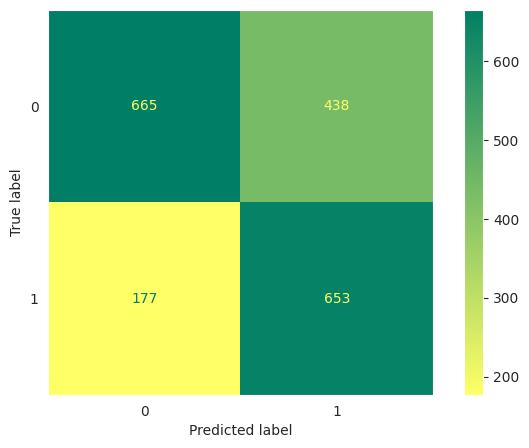

In [23]:
relatorios[modelo_numero] = avaliar_modelo(y_val, previsoes[modelo_numero])

In [24]:
relatorios[modelo_numero]

{'acurácia': 0.6818416968442835,
 'precisão': 0.7076652728288632,
 'revocação': 0.6818416968442835,
 'pontuação-f1': 0.6821083937915633}

### Camadas iniciais padronizadas

In [25]:
%%time

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas_iniciais = vetorizador(entradas)
camadas_iniciais = incorporador(camadas_iniciais)

CPU times: user 67.8 ms, sys: 1.02 ms, total: 68.8 ms
Wall time: 95.7 ms


### Modelo 1: MLP

In [26]:
%%time

modelo_numero = 1

modelos_nome[modelo_numero] = 'MLP'

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES_MLP,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/20
121/121 [==============================] - 38s 257ms/step - loss: 0.6688 - accuracy: 0.7130 - val_loss: 0.6425 - val_accuracy: 0.7993
Epoch 2/20
121/121 [==============================] - 26s 215ms/step - loss: 0.6034 - accuracy: 0.8635 - val_loss: 0.5698 - val_accuracy: 0.8624
Epoch 3/20
121/121 [==============================] - 25s 207ms/step - loss: 0.5137 - accuracy: 0.8735 - val_loss: 0.4877 - val_accuracy: 0.8702
Epoch 4/20
121/121 [==============================] - 24s 198ms/step - loss: 0.4247 - accuracy: 0.8780 - val_loss: 0.4207 - val_accuracy: 0.8707
Epoch 5/20
121/121 [==============================] - 25s 206ms/step - loss: 0.3519 - accuracy: 0.8835 - val_loss: 0.3712 - val_accuracy: 0.8758
Epoch 6/20
121/121 [==============================] - 20s 166ms/step - loss: 0.2950 - accuracy: 0.8916 - val_loss: 0.3350 - val_accuracy: 0.8805
Epoch 7/20
121/121 [==============================] - 20s 162ms/step - loss: 0.2493 - accuracy: 0.9087 - val_loss: 0.3083 - val_ac

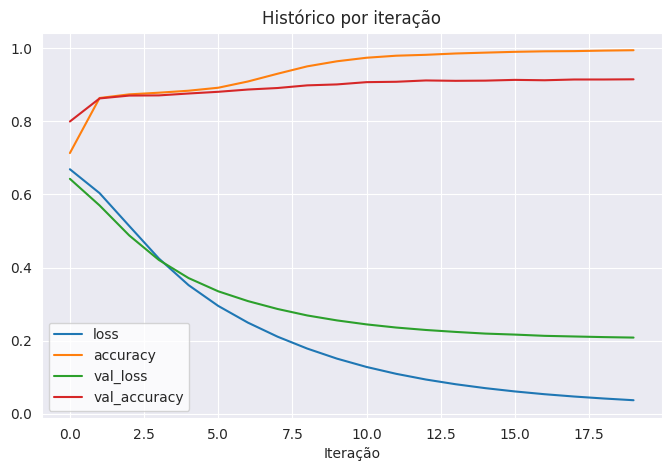

In [27]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1103
           1       0.94      0.86      0.90       830

    accuracy                           0.91      1933
   macro avg       0.92      0.91      0.91      1933
weighted avg       0.92      0.91      0.91      1933



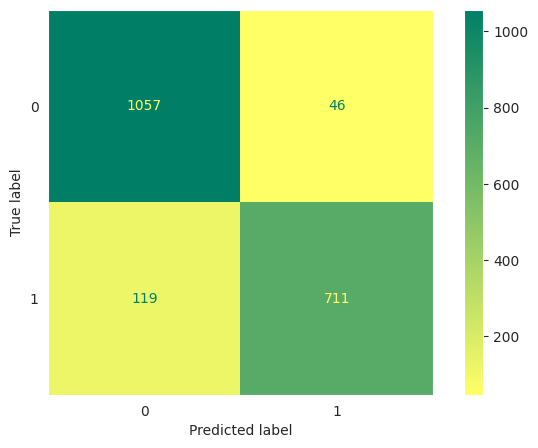

In [28]:
dados_modelo(modelo_numero)

In [29]:
relatorios[modelo_numero]

{'acurácia': 0.9146404552509053,
 'precisão': 0.9161670840424785,
 'revocação': 0.9146404552509053,
 'pontuação-f1': 0.9140443405980718}

### Modelo 2: CNN

In [30]:
%%time

modelo_numero = 2

modelos_nome[modelo_numero] = 'RNC'

camadas = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=NUCLEO_CONV,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas_iniciais)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 33s 231ms/step - loss: 0.5349 - accuracy: 0.7760 - val_loss: 0.4120 - val_accuracy: 0.8629
Epoch 2/3
121/121 [==============================] - 24s 196ms/step - loss: 0.2443 - accuracy: 0.9225 - val_loss: 0.3012 - val_accuracy: 0.8784
Epoch 3/3
121/121 [==============================] - 23s 192ms/step - loss: 0.1059 - accuracy: 0.9724 - val_loss: 0.2930 - val_accuracy: 0.8789
CPU times: user 1min 4s, sys: 1.64 s, total: 1min 6s
Wall time: 1min 20s


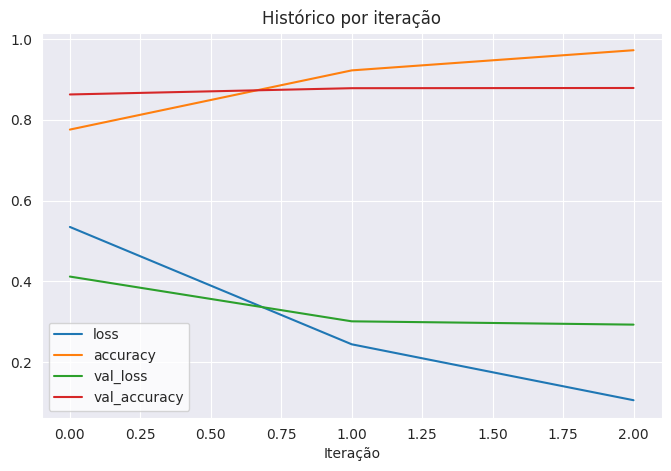

In [31]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1103
           1       0.86      0.86      0.86       830

    accuracy                           0.88      1933
   macro avg       0.88      0.88      0.88      1933
weighted avg       0.88      0.88      0.88      1933



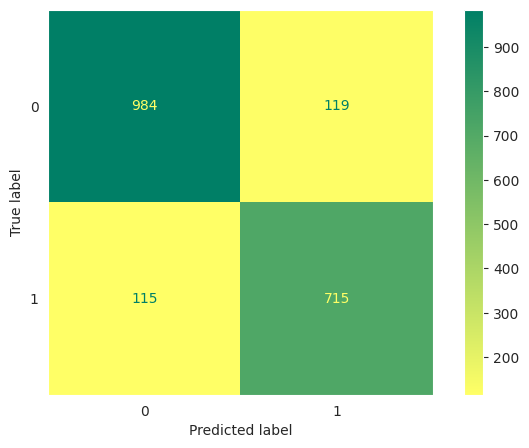

In [32]:
dados_modelo(modelo_numero)

In [33]:
relatorios[modelo_numero]

{'acurácia': 0.8789446456285567,
 'precisão': 0.8790233735519325,
 'revocação': 0.8789446456285567,
 'pontuação-f1': 0.8789801944852844}

### Modelo 3: DCNN

In [34]:
%%time

modelo_numero = 3

modelos_nome[modelo_numero] = 'CFN-AI'

# Bigram

bigram = Conv1D(filters=ESPACO_SAIDA,
                kernel_size=2,
                activation=ATIVACAO_CNN,
                padding=PREENCHIMENTO,
                name='camada_bigram')(camadas_iniciais)

bigram = GlobalMaxPool1D(name='agrupamento_maximo_bigram')(bigram)

# Trigram

trigram = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=3,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_trigram')(camadas_iniciais)

trigram = GlobalMaxPool1D(name='agrupamento_maximo_trigram')(trigram)

# Fourgram

fourgram = Conv1D(filters=ESPACO_SAIDA,
                  kernel_size=4,
                  activation=ATIVACAO_CNN,
                  padding=PREENCHIMENTO,
                  name='camada_fourgram')(camadas_iniciais)

fourgram = GlobalMaxPool1D(name='agrupamento_maximo_fourgram')(fourgram)

# Concatenação dos ngrams

# camadas = tf.concat([bigram, trigram, fourgram], axis=-1)
camadas = Concatenate(name="camada_concatenacao")([bigram, trigram, fourgram])

# Camada densa

camadas = Dense(units=512, activation=ATIVACAO_CNN, name='camada_densa')(camadas)

# Camada de abandono

camadas = Dropout(rate=ABANDONOS, name='camada_abandono')(camadas)

# Camada de saída

saidas = Dense(units=1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 28s 202ms/step - loss: 0.1785 - accuracy: 0.9365 - val_loss: 0.3834 - val_accuracy: 0.8712
Epoch 2/3
121/121 [==============================] - 22s 180ms/step - loss: 0.0242 - accuracy: 0.9920 - val_loss: 0.3941 - val_accuracy: 0.8810
Epoch 3/3
121/121 [==============================] - 23s 188ms/step - loss: 0.0080 - accuracy: 0.9966 - val_loss: 0.4879 - val_accuracy: 0.8810
CPU times: user 1min, sys: 1.27 s, total: 1min 1s
Wall time: 1min 23s


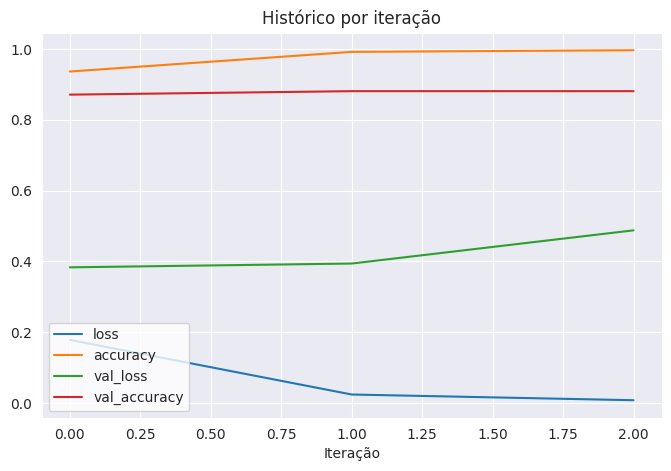

In [35]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1103
           1       0.82      0.92      0.87       830

    accuracy                           0.88      1933
   macro avg       0.88      0.89      0.88      1933
weighted avg       0.89      0.88      0.88      1933



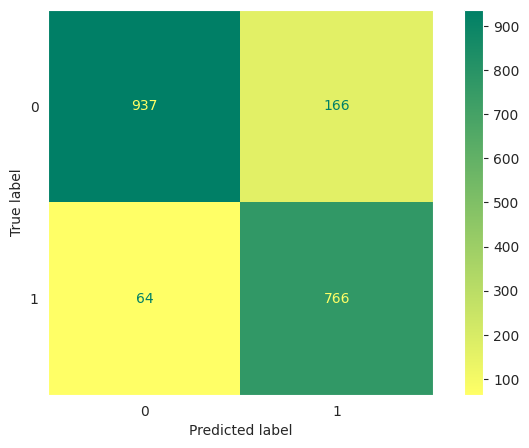

In [36]:
dados_modelo(modelo_numero)

In [37]:
relatorios[modelo_numero]

{'acurácia': 0.8810139679255043,
 'precisão': 0.887038749846234,
 'revocação': 0.8810139679255043,
 'pontuação-f1': 0.8815737778900503}

### Modelo 4: RNN (LSTM Bidirecional)

In [38]:
%%time

modelo_numero = 4

modelos_nome[modelo_numero] = 'RNR'

camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 40s 290ms/step - loss: 0.4735 - accuracy: 0.7676 - val_loss: 0.3229 - val_accuracy: 0.8748
Epoch 2/3
121/121 [==============================] - 34s 277ms/step - loss: 0.1241 - accuracy: 0.9583 - val_loss: 0.2724 - val_accuracy: 0.8883
Epoch 3/3
121/121 [==============================] - 34s 277ms/step - loss: 0.1063 - accuracy: 0.9666 - val_loss: 0.2971 - val_accuracy: 0.8950
CPU times: user 1min 34s, sys: 3.54 s, total: 1min 38s
Wall time: 1min 47s


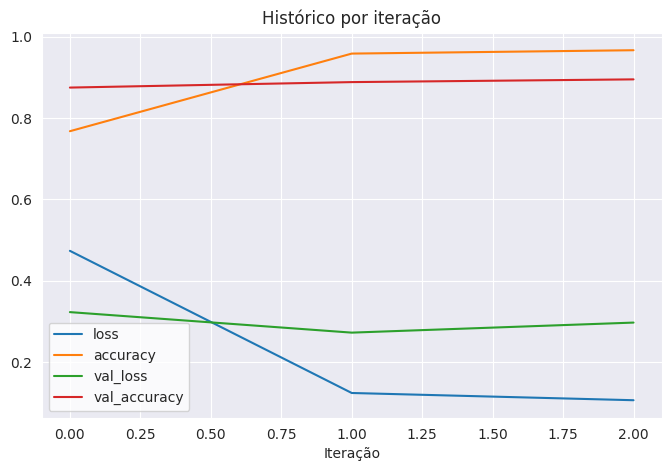

In [39]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 4s 46ms/step
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1103
           1       0.88      0.87      0.88       830

    accuracy                           0.89      1933
   macro avg       0.89      0.89      0.89      1933
weighted avg       0.89      0.89      0.89      1933



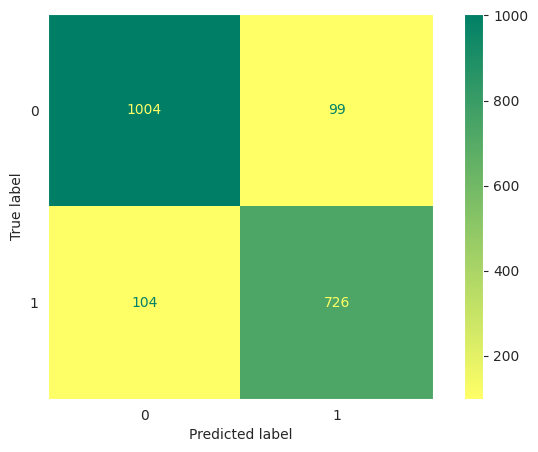

In [40]:
dados_modelo(modelo_numero)

In [41]:
relatorios[modelo_numero]

{'acurácia': 0.8949818934299018,
 'precisão': 0.8949142856075646,
 'revocação': 0.8949818934299018,
 'pontuação-f1': 0.8949420008389886}

### Modelo 5: Transformer

In [42]:
%%time

modelo_numero = 5

modelos_nome[modelo_numero] = 'Transformer'

tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder    = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2'

modelos[modelo_numero] = build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 84s 571ms/step - loss: 0.6106 - accuracy: 0.6627 - val_loss: 0.5124 - val_accuracy: 0.7289
Epoch 2/3
121/121 [==============================] - 59s 489ms/step - loss: 0.4169 - accuracy: 0.8022 - val_loss: 0.5036 - val_accuracy: 0.7574
Epoch 3/3
121/121 [==============================] - 56s 467ms/step - loss: 0.3038 - accuracy: 0.8674 - val_loss: 0.4404 - val_accuracy: 0.8148
CPU times: user 3min 36s, sys: 20.3 s, total: 3min 56s
Wall time: 3min 35s


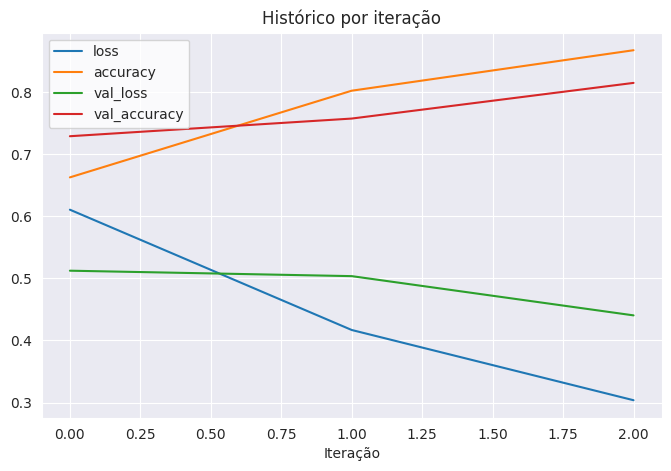

In [43]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 7s 114ms/step
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1103
           1       0.77      0.81      0.79       830

    accuracy                           0.81      1933
   macro avg       0.81      0.81      0.81      1933
weighted avg       0.82      0.81      0.82      1933



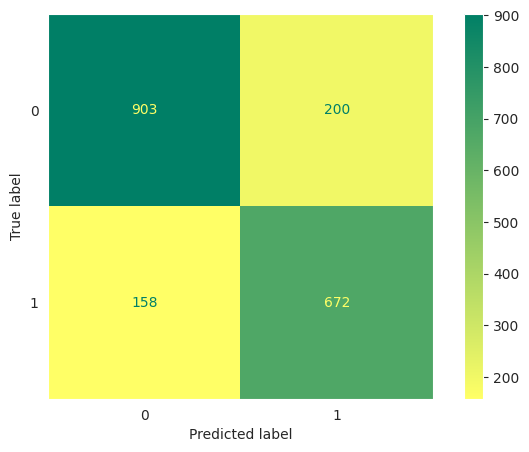

In [44]:
dados_modelo(modelo_numero)

In [45]:
relatorios[modelo_numero]

{'acurácia': 0.8147956544231764,
 'precisão': 0.8165434819525913,
 'revocação': 0.8147956544231764,
 'pontuação-f1': 0.8152835148941636}

### Modelo 6: fakeDETECTOR

In [46]:
%%time

modelo_numero = 6

modelos_nome[modelo_numero] = 'fakeD'

camadas = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=NUCLEO_CONV,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas_iniciais)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

camadas = Dense(ESPACO_SAIDA, activation=ATIVACAO_CNN, name='camada_densa')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 25s 193ms/step - loss: 0.1874 - accuracy: 0.9475 - val_loss: 0.3495 - val_accuracy: 0.8733
Epoch 2/3
121/121 [==============================] - 21s 175ms/step - loss: 0.0172 - accuracy: 0.9948 - val_loss: 0.4040 - val_accuracy: 0.8779
Epoch 3/3
121/121 [==============================] - 22s 180ms/step - loss: 0.0069 - accuracy: 0.9973 - val_loss: 0.4374 - val_accuracy: 0.8727
CPU times: user 58.6 s, sys: 1.04 s, total: 59.6 s
Wall time: 1min 22s


In [47]:
# grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1103
           1       0.86      0.84      0.85       830

    accuracy                           0.87      1933
   macro avg       0.87      0.87      0.87      1933
weighted avg       0.87      0.87      0.87      1933



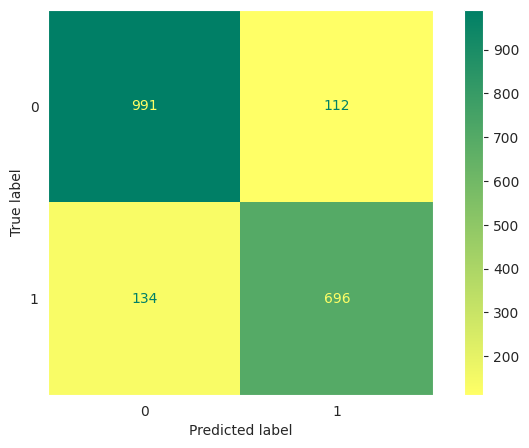

In [48]:
dados_modelo(modelo_numero)

In [49]:
relatorios[modelo_numero]

{'acurácia': 0.8727366787377134,
 'precisão': 0.8725147126197359,
 'revocação': 0.8727366787377134,
 'pontuação-f1': 0.8725103608578845}

### Modelo 7: fakeDETECTOR HDF5

In [50]:
%%time

modelo_numero = 7

modelos_nome[modelo_numero] = 'fakeD-H5'

# modelos[modelo_numero] = tf.keras.models.load_model('fakeDETECTOR_HDF5.h5')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


In [51]:
# grafico_historico_por_iteracao(historicos[modelo_numero])

In [52]:
# dados_modelo(modelo_numero)

In [53]:
relatorios[modelo_numero]

## Comparar modelos

In [54]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

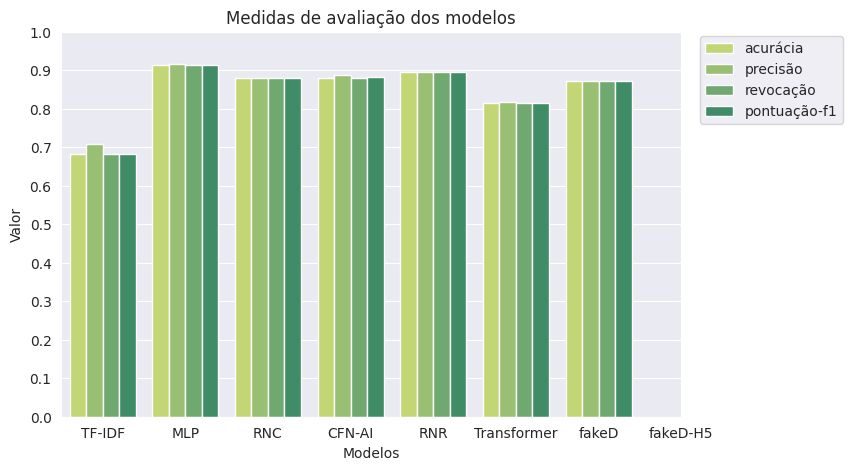

In [55]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.0, 1.0)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.xticks(ticks=np.arange(len(modelos_nome)), labels=modelos_nome)
plt.yticks(ticks=np.arange(0.0, 1.01, 0.1))

plt.legend(loc=(1.03, 0.76));